# Billiard project

## 1) Square case

Assume that there is no friction and the Descartes rules are satisfied.

A game to play with this billiard would be to create words associated to trajectories:

We start with an empty word. 
Then, when the ball hit the top or bottom part we add an H (H for horizontal) to the word and when the ball hit the left or right part, we add a V (V for vertical).
Once words are created, we are going to analyse them with respect to the angle use to start the trajectory. We will restrict to words of size < 2000


Let's start by creating a billard table.

In [6]:
#We import the fuction that we would need later
import numpy as np  
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as pch
from tkinter import *
%matplotlib notebook
import tkinter
import time
from math import *

In [64]:
from tkinter import *
#We define the function of the ball's movement: 
def deplacement():
    global dx, dy
    if canvas.coords(balle1)[3]>400:
        dy=-1*dy
    if (canvas.coords(balle1)[2]>400):
        dx=-1*dx
    if (canvas.coords(balle1)[1]<0):
        dy=-1*dy
    if (canvas.coords(balle1)[0]<0):
        dx=-1*dx
    #Ball's movement :
    canvas.move(balle1,dx,dy)
    #We reiterate this function 
    tk.after(20,deplacement)
 
#Deplacement de la balle au départ:
dx=3
dy=5
 
# We create a new window with the tkinter function 
window = tkinter.Tk()
tk = Tk()
tk.title("Square Billiard Game")
label_title=Label(tk,text="Welcome to billiard game")
label_title.pack()
canvas = tkinter.Canvas(tk, width="400", height="400",background='#096a09') #Dimension square are 400x400
canvas.pack(padx=10,pady=10)
 
#We create an "exit" button
Bouton_Quitter=Button(tk, text ='Quitter', command = tk.destroy)
#On ajoute l'affichage du bouton dans la fenêtre tk:
Bouton_Quitter.pack()
 
#We create a ball 
balle1 = canvas.create_oval(10,10,30,30,fill='white')
 
deplacement()
 
#On lance la boucle principale:
tk.mainloop()
  

TclError: invalid command name ".!canvas"

<IPython.core.display.Javascript object>


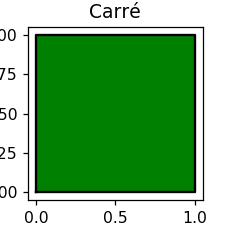

<IPython.core.display.Javascript object>


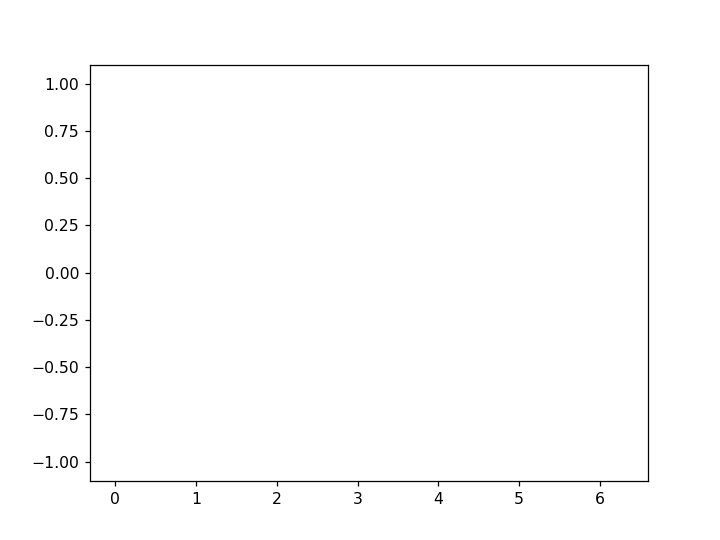

In [13]:
from tkinter import * 
fenetre = Tk()
fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    return line,


def animate(i):
    line.set_ydata(np.sin(x + i / 100))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)
writer = animation.FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
plt.show()

fenetre.title("Square Billiard Game")
fenetre.geometry("420x420")
fenetre.config(background='#096a09')
fenetre.mainloop()


We need to discribe parameters such that : 
- the position (x;y) for a ball that goes in different ways
- the initial angle (teta)
- t, where x = f(t) ans y = g(t) are the parametic equation  of the ball

We start by create the square billiard.

In [74]:
LARG = 300
HAUT = 300
def fond():
    line (LARG/2,0, LARG/2, HAUT)

We add a red ball to the square which move between right corner and left corner of the square. 
This ball will have this speed equal to 0 when it hit the corner.
We define the ball position as a periodic function with one parameter t. 
Here, x goes to 0 to LARG and y is a constant.

In [97]:
from math import *
t
def suivant(t):
    return t + 0.1
(x, y) = (LARG * (1 + sin(t)) / 2, HAUT / 2)

In [96]:
def dessine(t):
    fond()
    (x, y) = (LARG * (1 + sin(t)) / 2, HAUT / 2)
    ellipseMode(CENTER)
    ellipse (x, y, RBALLE, RBALLE)

We define the clock 's frequence : FREQ
Let's create the setup funtion which initialize the worl and 


In [21]:
# We create a new window with the tkinter function
window = tkinter.Tk()
window.geometry("600x400+600+300")
window.title("Square Billiard Game")
Bouton_Quitter=Button(window, text ='Quitter', command = tk.destroy)
Bouton_Quitter.pack()
label_title=Label(window,text="Welcome to billiard game")
label_title.pack()


x=0

canvas = tkinter.Canvas(window, width="400", height="400",background='#096a09') #Dimension square are 400x400
canvas.pack(padx=10,pady=10)

rond = canvas.create_oval(x,10,40,40,fill="white") # Ball's dimension
canvas.pack() #Insert ball to window

a=True #Create a boolean 
while 1:
    if (x==350): # if ball hit right corner, a is False
        a=False
    if (x==0):
        a=True   # if ball doesn't hit any corner, a is True
    if(a):
        canvas.move(rond,10,0) # if a is true then ball keep mooving from 10 to 10
        x+=10
    else:
        canvas.move(rond,-10,0)  # Otherwise, which means, a is false then ball is returning to the left or right part of the square
        x+=-10
        
    time.sleep(0.07) #ball's speed
    canvas.update()

window.mainloop()  
Bouton_Quitter=Button(window, text ='Quitter', command = tk.destroy)
Bouton_Quitter.pack()

#canvas.move(1,dx,dy)
#tk.after(20,deplacement)

#def droite(event):
   # canvas.move(raquette,10,0)
    
#def gauche(event):
  #  canvas.move(raquette,-10,0)

#canvas = Canvas(tk,width = 500, height = 400 , bd=0, bg="white")
#canvas.pack(padx=10,pady=10)
#balle1 = canvas.create_oval(20,20,40,40,fill='red')
#deplacement()
#tk.mainloop()
# We insert a ball inside square billiard and animate it 

 

In [46]:
tk = Tk()
canvas = tkinter.Canvas(tk, width="400", height="400",background='#096a09') 
canvas.pack(padx=10,pady=10)

Bouton_Quitter=Button(tk, text ='Quitter', command = tk.destroy)
Bouton_Quitter.pack()
balle1 = canvas.create_oval(10,10,30,30,fill='red')
tk.mainloop()
#canvas.move(1,dx,dy)
#tk.after(20,deplacement)

#def droite(event):
   # canvas.move(raquette,10,0)
    
#def gauche(event):
  #  canvas.move(raquette,-10,0)

#canvas = Canvas(tk,width = 500, height = 400 , bd=0, bg="white")
#canvas.pack(padx=10,pady=10)
#balle1 = canvas.create_oval(20,20,40,40,fill='red')
#deplacement()
#tk.mainloop()

We create countdown and n is the the number of picture left to print

In [10]:
%matplotlib notebook
LARG = 300
HAUT = 300
FREQ = 28
n=15

def suivant(n) :
     return n-1
    
def dessine(n):
     t = float(n) / FREQ
    
def setup() :
     global n
     size(LARG, HAUT)
     n = 10 * FREQ
     frameRate(FREQ)

def draw() :
     global n
     n = suivant(n)
     dessine(n)
     if n <= 0:
        return "stop"

In [ ]:
draw()

In [ ]:
Fenetre=Tk()#La fonction Tk() du module Tkinter permet de créer une fenêtre qui se nomme Fenetre
Fenetre.title
zone_dessin = Canvas(Fenetre,width=500,height=500,bg='green',bd=8,relief="ridge")
zone_dessin.create_rectangle(150,150,350,350)
zone_dessin.pack()
Fenetre.mainloop

In [77]:
from tkinter import *
 
def deplacement():
    global dx, dy
    if canvas.coords(balle1)[3]>400:
        dy=-1*dy
    if (canvas.coords(balle1)[2]>400):
        dx=-1*dx
    if (canvas.coords(balle1)[1]<0):
        dy=-1*dy
    if (canvas.coords(balle1)[0]<0):
        dx=-1*dx
    #On deplace la balle :
    canvas.move(balle1,dx,dy)
    #On repete cette fonction
    tk.after(20,deplacement)
 
#Deplacement de la balle au départ:
dx=6
dy=5
 
#On cree une fenetre et un canevas:
tk = Tk()
canvas = Canvas(tk,width = 400, height = 400 , bd=0, bg="white")
canvas.pack(padx=10,pady=10)
 
#Creation  d'un bouton "Quitter":
Bouton_Quitter=Button(tk, text ='Quitter', command = tk.destroy)
#On ajoute l'affichage du bouton dans la fenêtre tk:
Bouton_Quitter.pack()
 
#On cree une balle:
balle1 = canvas.create_oval(10,10,30,30,fill='red')
 
deplacement()
 
#On lance la boucle principale:
tk.mainloop()
  
 